In [ ]:
import os
from google.colab import userdata

In [ ]:
!nvidia-smi

Sat Apr 26 19:40:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install -q datasets evaluate
# !pip install fiftyone==0.23.0rc1
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platfor

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import os
# import fiftyone as fo
import shutil
import pandas as pd
import cv2
import random
import hashlib
from PIL import Image
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import TFSegformerForSemanticSegmentation
from transformers import create_optimizer
import torch
import numpy as np
from diffusers.utils import load_image, make_image_grid
import torch
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import copy
# from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler


In [ ]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
new_directory = '/content/drive/MyDrive/Segformer_training'

# Change the current working directory
os.chdir(new_directory)

# Verify the change by printing the current working directory
HOME = os.getcwd()
print("Current working directory:", HOME)

Current working directory: /content/drive/MyDrive/Segformer_training


In [ ]:
# 1) Uninstall any stray torchvision
!pip uninstall -y torchvision

# 2) Re-install torch and torchvision together with CUDA 11.8 wheels
!pip install -q \
    torch==2.1.0+cu118 \
    torchvision==0.16.0+cu118 \
    --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 28.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.29.post3 requires torch==2.6.0, but you have torch 2.1.0+cu118 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.1.0+cu118 which is incompatible.


In [ ]:
!pip uninstall -y xformers

In [ ]:
H,W = 512,512
BATCH_SIZE = 2
N_CLASSES = 24
LR = 5e-5
N_EPOCHS = 20
WEIGHT_DECAY_RATE = 0.01
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]
checkpoint_filepath = "/content/drive/MyDrive/fiftyone/segformer_b5_clothing.h5"

# Downloads

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

Dataset URL: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation
License(s): CC0-1.0


In [ ]:
!unzip "./people-clothing-segmentation.zip" -d "./dataset/"

Archive:  ./people-clothing-segmentation.zip
  inflating: ./dataset/jpeg_images/IMAGES/img_0001.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0002.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0003.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0004.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0005.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0006.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0007.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0008.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0009.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0010.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0011.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0012.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0013.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0014.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0015.jpeg  
  inflating: ./dataset/jpeg_images/IMAGES/img_0016.jpeg  
  inflating: ./dataset/jpeg

In [ ]:
df = pd.read_csv("./dataset/labels.csv")

In [ ]:
id2label = {}
for i,j in df.iterrows():
  if i==0:
    id2label[i] = 'nan'
  else:
    id2label[i] = j['label_list']

In [ ]:
label2id = {label: id for id,label in id2label.items()}

In [ ]:
print(label2id)
print(len(label2id))

{'nan': 0, 'accessories': 1, 'bag': 2, 'belt': 3, 'blazer': 4, 'blouse': 5, 'bodysuit': 6, 'boots': 7, 'bra': 8, 'bracelet': 9, 'cape': 10, 'cardigan': 11, 'clogs': 12, 'coat': 13, 'dress': 14, 'earrings': 15, 'flats': 16, 'glasses': 17, 'gloves': 18, 'hair': 19, 'hat': 20, 'heels': 21, 'hoodie': 22, 'intimate': 23, 'jacket': 24, 'jeans': 25, 'jumper': 26, 'leggings': 27, 'loafers': 28, 'necklace': 29, 'panties': 30, 'pants': 31, 'pumps': 32, 'purse': 33, 'ring': 34, 'romper': 35, 'sandals': 36, 'scarf': 37, 'shirt': 38, 'shoes': 39, 'shorts': 40, 'skin': 41, 'skirt': 42, 'sneakers': 43, 'socks': 44, 'stockings': 45, 'suit': 46, 'sunglasses': 47, 'sweater': 48, 'sweatshirt': 49, 'swimwear': 50, 't-shirt': 51, 'tie': 52, 'tights': 53, 'top': 54, 'vest': 55, 'wallet': 56, 'watch': 57, 'wedges': 58}
59


# Data Preparation

In [ ]:
im_path = "./dataset/png_images/IMAGES/"
anno_path = "./dataset/png_masks/MASKS/"
val_im_path = "./val_dataset/png_images/IMAGES/"
val_anno_path = "./val_dataset/png_masks/MASKS/"

In [ ]:
for fname in os.listdir(anno_path):
  os.rename(anno_path+fname,anno_path+"img"+fname[3:])

## Split Data

In [ ]:
!mkdir ./val_dataset/
!mkdir ./val_dataset/png_images/
!mkdir ./val_dataset/png_masks/
!mkdir ./val_dataset/png_images/IMAGES/
!mkdir ./val_dataset/png_masks/MASKS/

In [ ]:
val_list=["0115","0025","0010","0003","0125","0200","0515","0225","0805","0915","0630","0301","0112","0905","0823","0527","0088","0055","0018",
          "0222","0049","0273","0299","0282","0372","0027","0445","0582","0374","0956","0211","0019","0961","0397","0699","0789","0996","0290",
          "0110","0315","0335","0419","0666","0525","0927","0555","0275","0855","0815","0130","0371","0412","0105","0423","0507","0028","0035","0118",
          "0232","0849","0673","0688","0777","0472","0991","0485","0592","0334","0827","0651","0619","0567","0393","0609","0719","0916","0190",
          ]

In [ ]:
import shutil

In [ ]:
for name in val_list:
  shutil.move(im_path+"img_"+name+".png", val_im_path+"img_"+name+".png")
  shutil.move(anno_path+"img_"+name+".png", val_anno_path+"img_"+name+".png")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([im_path+i for i in os.listdir(im_path)],
    [anno_path+"img"+i[3:] for i in os.listdir(im_path)])
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ([val_im_path+i for i in os.listdir(val_im_path)],
    [val_anno_path+"img"+i[3:] for i in os.listdir(val_im_path)])
)

In [ ]:
for i in train_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/png_images/IMAGES/img_0001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/png_masks/MASKS/img_0001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/png_images/IMAGES/img_0002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/png_masks/MASKS/img_0002.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/png_images/IMAGES/img_0004.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/png_masks/MASKS/img_0004.png'>)


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./val_dataset/png_images/IMAGES/img_0003.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./val_dataset/png_masks/MASKS/img_0003.png'>)


In [ ]:
len(train_dataset)

923

In [ ]:
len(val_dataset)

77

## Preprocess Data

In [ ]:
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]


In [ ]:
def preprocess(im_path, anno_path):
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD

  anno = tf.io.decode_jpeg(tf.io.read_file(anno_path))
  anno = tf.cast(tf.squeeze(anno,-1),tf.float32)

  return img, anno

In [ ]:
prep_train_ds = (
    train_dataset
    .map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
)
prep_val_ds = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

In [ ]:
for i,j in prep_train_ds.take(1):
  print(i.shape,j.shape)

(825, 550, 3) (825, 550)


## Data Augmentation

In [ ]:
H,W = 512,512

In [ ]:
transform = A.Compose([
    A.RandomCrop (H,W, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.Transpose(p=0.3),
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.1),
    A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),
                    num_shadows_lower=1, num_shadows_upper=2,
                    shadow_dimension=5, p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    #A.Resize(H,W),
])

val_transform = A.Compose([
    A.Resize(H,W),
])

<ipython-input-124-c936e653a1f3>:8: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),


In [ ]:
def aug_albument(image,mask):
  augmented = transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]
def val_aug_albument(image,mask):
  augmented = val_transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

In [ ]:
def augment(image,mask):
  aug_output = tf.numpy_function(func=aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

def val_augment(image,mask):
  aug_output = tf.numpy_function(func=val_aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}


In [ ]:
BATCH_SIZE = 2
train_ds = (
    prep_train_ds
    .shuffle(10)
    .map(augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    prep_val_ds
    .map(val_augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in train_ds.take(1):
  data = i

  print(i)

{'pixel_values': <tf.Tensor: shape=(2, 3, 512, 512), dtype=float32, numpy=
array([[[[ 0.2966863 ,  0.34806058,  0.43368435, ...,  0.2281873 ,
           0.21106254,  0.38231006],
         [ 0.31381106,  0.34806058,  0.36518532, ...,  0.5193081 ,
          -0.08005828,  0.31381106],
         [ 0.34806058,  0.34806058,  0.34806058, ...,  0.69055563,
           0.02269025,  0.21106254],
         ...,
         [ 0.53643286,  0.55355763,  0.5193081 , ..., -0.30268008,
          -0.30268008, -0.13143253],
         [ 0.4850586 ,  0.5021834 ,  0.46793383, ..., -0.2170563 ,
          -0.26843056, -0.19993155],
         [ 0.43368435,  0.4508091 ,  0.41655958, ..., -0.37117907,
          -0.38830385, -0.3369296 ]],

        [[ 0.38025212,  0.43277314,  0.52030814, ...,  0.41526613,
           0.43277314,  0.60784316],
         [ 0.31022412,  0.34523812,  0.36274514, ...,  0.7303922 ,
           0.11764708,  0.52030814],
         [ 0.2927171 ,  0.2927171 ,  0.2927171 , ...,  0.8529412 ,
          

## Data Visualization

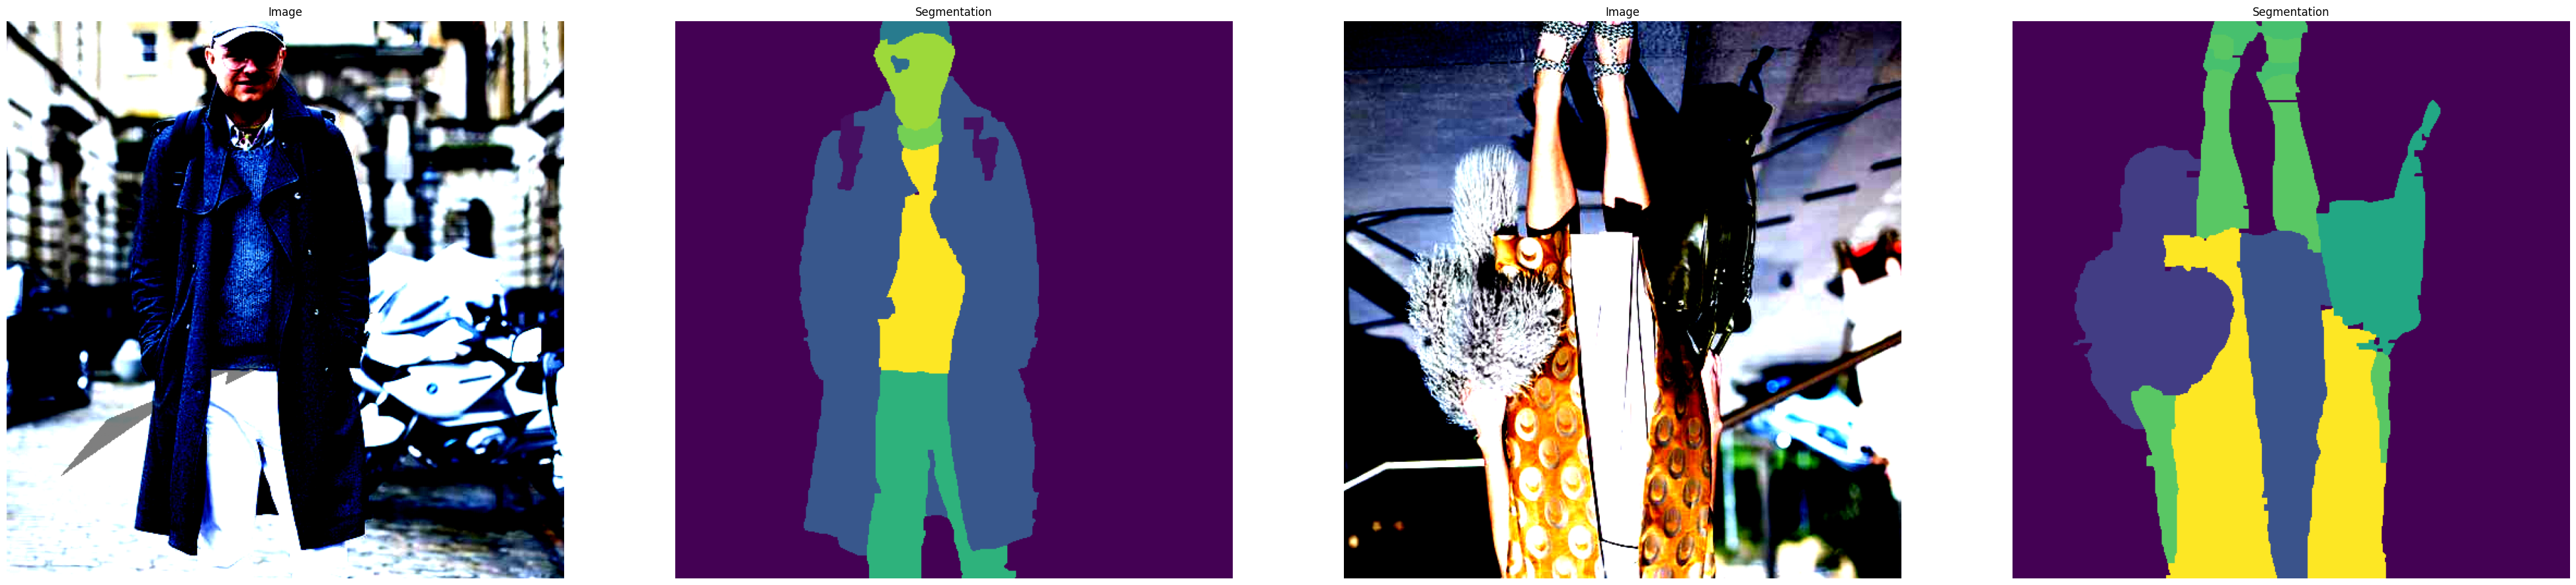

In [ ]:
plt.figure(figsize = (50,50))

for data in train_ds.take(1):
  images=data['pixel_values']
  labels=data['labels']
  for i in range(BATCH_SIZE*2):
    if i==4:
      break
    ax = plt.subplot(1,BATCH_SIZE*2, i+1)
    if i%2==0:
      plt.imshow(tf.transpose(images[i//2], (1, 2, 0)))
      plt.title("Image")
    else:
      plt.imshow(labels[i//2])
      plt.title("Segmentation")
    plt.axis("off")
  plt.show()

# WOrking with Voxel51

In [ ]:
name = "clothing-dataset-1"
data_path = "/val_dataset/png_images/IMAGES"
labels_path = "/content/val_dataset/png_masks/MASKS"
# Create the dataset
dataset = fo.Dataset.from_dir(
    data_path=data_path,
    labels_path=labels_path,
    dataset_type=fo.types.ImageSegmentationDirectory,
    name=name,
)

# View summary info about the dataset
print(dataset)

# Print the first few samples in the dataset
print(dataset.head())

 100% |███████████████████| 77/77 [94.5ms elapsed, 0s remaining, 814.8 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 77/77 [94.5ms elapsed, 0s remaining, 814.8 samples/s]  


Name:        clothing-dataset-1
Media type:  image
Num samples: 77
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)
[<Sample: {
    'id': '65d6ee97c605f3292f7c8e34',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0003.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '65d6ee97c605f3292f7c8e33',
        'tags': [],
        'mask': None,
        'mask_path': '/content/val_dataset/png_masks/MASKS/img_0003.png',
    }>,
}>, <Sample: {
    'id': '65d6ee97c605f3292f7c8e37',
    'media_type': 'image',
    'filepath': '/content/val_da

In [ ]:
print(dataset.tail())

[<Sample: {
    'id': '65d6ee97c605f3292f7c8eca',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0961.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '65d6ee97c605f3292f7c8ebc',
        'tags': [],
        'mask': None,
        'mask_path': '/content/val_dataset/png_masks/MASKS/img_0961.png',
    }>,
}>, <Sample: {
    'id': '65d6ee97c605f3292f7c8ecb',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0991.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentation: {
        'id': '65d6ee97c605f3292f7c8ebd',
        'tags': [],
        'mask': None,
        'mask_path': '/content/val_dataset/png_masks/MASKS/img_0991.png',
    }>,
}>, <Sample: {
    'id': '65d6ee97c605f3292f7c8ecc',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0996.png',
    'tags': [],
    'metadata': None,
    'ground_truth': <Segmentat

## Download Plugins

In [ ]:
!fiftyone plugins download https://github.com/voxel51/fiftyone-plugins --plugin-names @voxel51/plugins


Copying plugin '@voxel51/plugins' to '/root/fiftyone/__plugins__/@voxel51/plugins'


In [ ]:
!fiftyone plugins download https://github.com/Neuralearn/data_augment --plugin-names @Neuralearn/data_augment


Copying plugin '@Neuralearn/data_augment' to '/root/fiftyone/__plugins__/@Neuralearn/data_augment'


## Evaluation with FiftyOne

In [ ]:
H_resized, W_resized = 512,512
H_init, W_init = 825,550
import evaluate
metric = evaluate.load("mean_iou")

In [ ]:
for i,sample in enumerate(dataset):

  img = tf.io.decode_jpeg(tf.io.read_file(sample.filepath))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits
  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0]
  sample["pred"] = fo.Segmentation(mask=resized_output.numpy())

  mask = cv2.imread(sample["ground_truth"]["mask_path"], cv2.IMREAD_GRAYSCALE)
  metrics = metric.compute(
      predictions = [resized_output.numpy()],
      references = [mask],
      num_labels = len(label2id),
      ignore_index = 0,
      nan_to_num=0,
      reduce_labels=False
  )


  sample["mean_iou"] = metrics["mean_iou"]
  sample["mean_accuracy"] = metrics["mean_accuracy"]
  sample["overall_accuracy"] = metrics["overall_accuracy"]

  for k,c in enumerate(metrics["per_category_iou"]):
    if c>0.0001:
      key = id2label[k]+"_iou"### e.g. shoes_iou
      sample[key] = c

  sample.save()

In [ ]:
model(tf.ones([1,3,512,512])).logits.shape

TensorShape([1, 59, 128, 128])

## Viz

In [ ]:
dataset.default_mask_targets = id2label
session = fo.launch_app(dataset,port=51)

# Modeling

In [ ]:
model_id = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels = len(label2id),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head/classifier/kernel:0: found shape (1, 1, 768, 19) in the checkpoint and (1, 1, 768, 59) in the model instantiated
- decode_head/classifier/bias:0: found shape (19,) in the checkpoint and (59,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  81443008  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  3197243   
 codeHead)                                                       
                                                                 
Total params: 84640251 (322.88 MB)
Trainable params: 84638715 (322.87 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


In [ ]:
H,W = 512,512

In [ ]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 128, 128])

In [ ]:
model.load_weights(checkpoint_filepath)

# Training and Evaluation

In [ ]:
!pip install -q datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

In [ ]:
import evaluate
metric = evaluate.load("mean_iou")


In [ ]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 128, 128])

In [ ]:
512,512

(512, 512)

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  logits = tf.transpose(logits, perm=[0,2,3,1])
  logits_resized =tf.image.resize(
      logits,
      size=tf.shape(labels)[1:],
      method="bilinear"
  )
  pred_labels = tf.argmax(logits_resized, axis=-1)

  metrics = metric.compute(
      predictions = pred_labels,
      references = labels,
      num_labels = len(label2id),
      ignore_index = 0,
  )

  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

  return {"val_" + k: v for k, v in metrics.items()}

In [ ]:
batch_size   = 4
num_epochs   = 50
num_train_steps = len(train_ds) // batch_size * num_epochs

# Optimizer & LR schedule
optimizer, lr_schedule = create_optimizer(
    init_lr=6e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=500,
)

from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_ds,
    batch_size=batch_size,
    label_cols=["labels"]
)
callbacks = [metric_callback]

model.compile(optimizer=optimizer)
history = model.fit(
    train_ds.batch(batch_size),
    validation_data=val_ds.batch(batch_size),
    epochs=num_epochs,
    callbacks=callbacks,
)

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1652, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file4e9c2m8o.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_file9tizqhnk.py", line 54, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).segformer, (ag__.ld(pixel_values),), dict(output_attentions=ag__.ld(output_attentions), output_hidden_states=True, return_dict=ag__.ld(return_dict)), fscope)
    File "/tmp/__autograph_generated_file4e9c2m8o.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_fileukuk_jxb.py", line 14, in tf__call
        pixel_values = ag__.converted_call(ag__.ld(tf).transpose, (ag__.ld(pixel_values),), dict(perm=(0, 2, 3, 1)), fscope)

    ValueError: Exception encountered when calling layer 'tf_segformer_for_semantic_segmentation' (type TFSegformerForSemanticSegmentation).
    
    in user code:
    
        File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 964, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/modeling_tf_segformer.py", line 994, in call  *
            outputs = self.segformer(
        File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file4e9c2m8o.py", line 40, in tf__run_call_with_unpacked_inputs
            raise
        File "/tmp/__autograph_generated_fileukuk_jxb.py", line 14, in tf__call
            pixel_values = ag__.converted_call(ag__.ld(tf).transpose, (ag__.ld(pixel_values),), dict(perm=(0, 2, 3, 1)), fscope)
    
        ValueError: Exception encountered when calling layer 'segformer' (type TFSegformerMainLayer).
        
        in user code:
        
            File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 964, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/modeling_tf_segformer.py", line 597, in call  *
                pixel_values = tf.transpose(pixel_values, perm=(0, 2, 3, 1))
        
            ValueError: Dimension must be 5 but is 4 for '{{node tf_segformer_for_semantic_segmentation/segformer/transpose}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](IteratorGetNext:1, tf_segformer_for_semantic_segmentation/segformer/transpose/perm)' with input shapes: [?,?,?,?,?], [4].
        
        
        Call arguments received by layer 'segformer' (type TFSegformerMainLayer):
          • pixel_values=tf.Tensor(shape=(None, None, None, None, None), dtype=float32)
          • output_attentions=False
          • output_hidden_states=True
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_segformer_for_semantic_segmentation' (type TFSegformerForSemanticSegmentation):
      • pixel_values={'pixel_values': 'tf.Tensor(shape=(None, None, None, None, None), dtype=float32)', 'labels': 'tf.Tensor(shape=<unknown>, dtype=float32)'}
      • labels=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None


In [ ]:
batch_size = 4
num_epochs = 50
num_train_steps = len(train_ds) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps= 500,
)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_ds,
    batch_size=batch_size,
    label_cols=["labels"]
)
callbacks = [metric_callback]

In [ ]:
model.compile(optimizer=optimizer)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=callbacks,
)

Epoch 1/50
462/462 [==============================] - ETA: 0s - loss: 2.4278

/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


462/462 [==============================] - 329s 445ms/step - loss: 2.4278 - val_loss: 0.8789 - val_mean_iou: 0.0237 - val_mean_accuracy: 0.0530 - val_overall_accuracy: 0.3094 - val_accuracy_nan: nan - val_accuracy_accessories: 0.0000e+00 - val_accuracy_bag: 0.0066 - val_accuracy_belt: 0.0000e+00 - val_accuracy_blazer: 0.0000e+00 - val_accuracy_blouse: 5.1243e-05 - val_accuracy_bodysuit: 0.0000e+00 - val_accuracy_boots: 0.0000e+00 - val_accuracy_bra: nan - val_accuracy_bracelet: 0.0000e+00 - val_accuracy_cape: 0.0000e+00 - val_accuracy_cardigan: 0.0000e+00 - val_accuracy_clogs: nan - val_accuracy_coat: 0.2789 - val_accuracy_dress: 0.7998 - val_accuracy_earrings: nan - val_accuracy_flats: 0.0000e+00 - val_accuracy_glasses: 0.0000e+00 - val_accuracy_gloves: 0.0000e+00 - val_accuracy_hair: 0.0000e+00 - val_accuracy_hat: 0.0000e+00 - val_accuracy_heels: 0.0000e+00 - val_accuracy_hoodie: nan - val_accuracy_intimate: nan - val_accuracy_jacket: 0.0000e+00 - val_accuracy_jeans: 1.1743e-04 - val

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


462/462 [==============================] - 133s 287ms/step - loss: 0.9226 - val_loss: 0.5582 - val_mean_iou: 0.0590 - val_mean_accuracy: 0.0998 - val_overall_accuracy: 0.4547 - val_accuracy_nan: nan - val_accuracy_accessories: 0.0000e+00 - val_accuracy_bag: 0.6974 - val_accuracy_belt: 0.0000e+00 - val_accuracy_blazer: 0.0000e+00 - val_accuracy_blouse: 0.0297 - val_accuracy_bodysuit: 0.0000e+00 - val_accuracy_boots: 0.0000e+00 - val_accuracy_bra: nan - val_accuracy_bracelet: 0.0000e+00 - val_accuracy_cape: 0.0000e+00 - val_accuracy_cardigan: 0.0000e+00 - val_accuracy_clogs: nan - val_accuracy_coat: 0.6184 - val_accuracy_dress: 0.8066 - val_accuracy_earrings: nan - val_accuracy_flats: 0.0000e+00 - val_accuracy_glasses: 0.0000e+00 - val_accuracy_gloves: 0.0000e+00 - val_accuracy_hair: 0.7502 - val_accuracy_hat: 0.0000e+00 - val_accuracy_heels: 0.0000e+00 - val_accuracy_hoodie: nan - val_accuracy_intimate: nan - val_accuracy_jacket: 0.0000e+00 - val_accuracy_jeans: 3.5880e-04 - val_accurac

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/Segformer_training/segformer_b5_clothing.h5"


In [ ]:
from transformers import TFSegformerForSemanticSegmentation

model = TFSegformerForSemanticSegmentation.from_pretrained(checkpoint_filepath)

OSError: It looks like the config file at '/content/drive/MyDrive/Segformer_training/segformer_b5_clothing.h5' is not a valid JSON file.

In [ ]:
from transformers import TFSegformerForSemanticSegmentation

# replace with the exact base model you fine-tuned, e.g. "nvidia/segformer-b5"
model = TFSegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")


All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [ ]:
from transformers import SegformerConfig, TFSegformerForSemanticSegmentation

config = SegformerConfig.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model  = TFSegformerForSemanticSegmentation(config)

In [ ]:

model.load_weights(checkpoint_filepath)

ValueError: Cannot assign value to variable ' tf_segformer_for_semantic_segmentation_5/decode_head/classifier/kernel:0': Shape mismatch.The variable shape (1, 1, 768, 19), and the assigned value shape (1, 1, 768, 59) are incompatible.

In [ ]:

model.save_weights(checkpoint_filepath)

NameError: name 'model' is not defined

# Generating New Samples

## Image Editing

In [ ]:
H_resized,W_resized = 512,512
H_init,W_init = 825,550

In [ ]:
label2id

{'nan': 0,
 'accessories': 1,
 'bag': 2,
 'belt': 3,
 'blazer': 4,
 'blouse': 5,
 'bodysuit': 6,
 'boots': 7,
 'bra': 8,
 'bracelet': 9,
 'cape': 10,
 'cardigan': 11,
 'clogs': 12,
 'coat': 13,
 'dress': 14,
 'earrings': 15,
 'flats': 16,
 'glasses': 17,
 'gloves': 18,
 'hair': 19,
 'hat': 20,
 'heels': 21,
 'hoodie': 22,
 'intimate': 23,
 'jacket': 24,
 'jeans': 25,
 'jumper': 26,
 'leggings': 27,
 'loafers': 28,
 'necklace': 29,
 'panties': 30,
 'pants': 31,
 'pumps': 32,
 'purse': 33,
 'ring': 34,
 'romper': 35,
 'sandals': 36,
 'scarf': 37,
 'shirt': 38,
 'shoes': 39,
 'shorts': 40,
 'skin': 41,
 'skirt': 42,
 'sneakers': 43,
 'socks': 44,
 'stockings': 45,
 'suit': 46,
 'sunglasses': 47,
 'sweater': 48,
 'sweatshirt': 49,
 'swimwear': 50,
 't-shirt': 51,
 'tie': 52,
 'tights': 53,
 'top': 54,
 'vest': 55,
 'wallet': 56,
 'watch': 57,
 'wedges': 58}

In [ ]:
import numpy as np
import tensorflow as tf

# 1) Parameters
batch_size = 2                   # whatever you used for validation
ignore_index = 0                  # assuming 0 is your “background” ignore ID
num_classes = len(label2id)       # total including background

# 2) Utility to accumulate preds & gts
all_preds = []
all_labels = []

for batch in val_ds.batch(batch_size):
    # batch is a dict with "pixel_values" and "labels"
    pixel_values = batch["pixel_values"]
    true_labels  = batch["labels"]   # shape (B, H, W)

    # 3) Forward pass
    outputs = model(pixel_values, training=False)
    logits  = outputs.logits         # shape (B, C, H', W')

    # 4) Resize & take argmax
    #   match logits → (B, H, W, C)
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    logits = tf.image.resize(
        logits,
        size=tf.shape(true_labels)[1:],
        method="bilinear"
    )
    preds = tf.argmax(logits, axis=-1)  # shape (B, H, W), dtype=int64

    all_preds.append(preds.numpy().ravel())
    all_labels.append(true_labels.numpy().ravel())

# 5) Concatenate and filter out ignored pixels
all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
mask       = all_labels != ignore_index
all_preds  = all_preds[mask]
all_labels = all_labels[mask]

# 6) Compute per‐class accuracy
class_acc = {}
for class_id, class_name in id2label.items():
    if class_id == ignore_index:
        continue
    idxs = (all_labels == class_id)
    if np.sum(idxs) == 0:
        class_acc[class_name] = np.nan
    else:
        class_acc[class_name] = float((all_preds[idxs] == all_labels[idxs]).mean())

# 7) Print results
print("Class-wise accuracy on validation set:")
for name, acc in class_acc.items():
    print(f"  {name:20s}: {acc*100:5.2f}%")

NameError: name 'val_ds' is not defined

In [ ]:
def compute_metrics(y_true, y_pred, num_classes):
    '''
    Computes IOU and Dice Score.

    Args:
        y_true (tensor) - ground truth label map
        y_pred (tensor) - predicted label map
    '''

    class_wise_iou = []
    class_wise_dice_score = []

    smoothening_factor = 0.00001
    y_true_reshape = np.reshape(y_true, y_pred.shape)

    for i in range(num_classes):
        intersection = np.sum((y_pred == i) * (y_true_reshape == i))
        y_true_area = np.sum(y_true_reshape == i)
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)

        dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [ ]:
# Get labels from csv file
import pandas as pd
csv_file = pd.read_csv('/content/drive/MyDrive/Segformer_training/dataset/labels.csv')
class_names = list(tuple(csv_file['label_list']))
class_names[0] = 'background'

In [ ]:
cls_wise_iou, cls_wise_dice_score = compute_metrics(test_y, results, len(class_names))

# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou))

NameError: name 'test_y' is not defined

In [ ]:
def generate_inputs(im_path, mask_label):
  mask_id = label2id[mask_label]
  print(mask_id)

  source_image = cv2.imread(im_path)

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img, tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits

  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0].numpy()
  mask = resized_output+(-mask_id*np.ones_like(resized_output))

  mask = 255-np.clip(1e10*np.multiply(mask,mask),a_min=0, a_max=255)
  cv2.imwrite("mask_6.jpg", mask)

  return source_image.shape, output.shape, mask.shape

In [ ]:
generate_inputs("./val_dataset/png_images/IMAGES/img_0003.png","coat")

13


OverflowError: Python integer -13 out of bounds for uint8

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/50 [00:00<?, ?it/s]

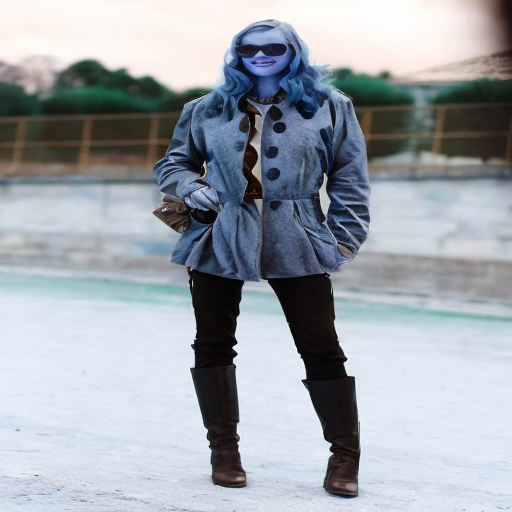

In [ ]:
prompt = "A photorealistic photo of a woman wearing a green-colored nice looking coat all green high resolution"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image, mask_image = generate_inputs(
    "/content/val_dataset/png_images/IMAGES/img_0003.png","coat")

image = pipe(prompt=prompt, image=image, mask_image=mask_image, ).images[0]
image.resize((W_init, H_init))
display(image.resize((550,825)))

## Data AUgmentation

In [ ]:
model_id = "stabilityai/stable-diffusion-2-inpainting"

In [ ]:
def create_pipeline(model_id):
  scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
  pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id,
                                                        scheduler=scheduler,
                                                        revision="fp16",
                                                        torch_dtype=torch.float16)

  pipe = pipe.to("cuda")
  pipe.enable_xformers_memory_efficient_attention()
  return pipe

In [ ]:
pipeline = create_pipeline(model_id)

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
from torchvision import transforms
def generate_inputs(im_path,mask_path, mask_id):
  #source_image = cv2.imread(im_path)
  source_image = Image.open(im_path)
  source_image = img.convert("RGB")
  sd_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

  out = (sd_mask+(-mask_id*np.ones_like(sd_mask)))
  mask=-(np.clip(1e10*np.multiply(out,out),a_min=0,a_max=255)-255)
  cv2.imwrite("mask.jpg", mask)
  pil_image = source_image.resize((512,512))
  pil_mask = Image.fromarray(mask).resize((512,512))

  return pil_image, pil_mask

In [ ]:
def augpaint(pipe, prompt, pil_image, pil_mask, guidance_scale, num_inference_steps):

  num_images_per_prompt = 1
  generator = torch.Generator(device="cuda").manual_seed(10)

  encoded_images = []

  for i in range(num_images_per_prompt):
    image = pipe(prompt=prompt, guidance_scale=guidance_scale,
                  num_inference_steps=num_inference_steps, generator=generator,
                  image=pil_image, mask_image=pil_mask, strength=0.99).images[0]



    encoded_images.append(image.resize((550,825)))
  return encoded_images[0]

In [ ]:

def create_hash():
  randint = random.randint(0, 100000000)
  hash = hashlib.sha256(str(randint).encode("utf-8")).hexdigest()[:10]
  return hash

In [ ]:
create_hash()

'ca34dee514'

In [ ]:
def list_classes(mask_path):

  mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
  list_unique = np.unique(mask)
  return list_unique

In [ ]:
guidance_scale = 8
num_inference_steps = 25


val_im_path = "/content/val_dataset/png_images/IMAGES/"
val_anno_path = "/content/val_dataset/png_masks/MASKS/"

In [ ]:
dataset.head()

[<Sample: {
     'id': '65d62bf37ba142b66e64bcbf',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0003.png',
     'tags': [],
     'metadata': None,
     'ground_truth': <Segmentation: {
         'id': '65d62bf37ba142b66e64bcbe',
         'tags': [],
         'mask': None,
         'mask_path': '/content/val_dataset/png_masks/MASKS/img_0003.png',
     }>,
 }>,
 <Sample: {
     'id': '65d62bf37ba142b66e64bcc2',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0010.png',
     'tags': [],
     'metadata': None,
     'ground_truth': <Segmentation: {
         'id': '65d62bf37ba142b66e64bcc0',
         'tags': [],
         'mask': None,
         'mask_path': '/content/val_dataset/png_masks/MASKS/img_0010.png',
     }>,
 }>,
 <Sample: {
     'id': '65d62bf37ba142b66e64bcc3',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0018.png',
     'tags': [],
     'metadata': None,

In [ ]:
def transform_sample(sample, select_class, prompt):
  hash = create_hash()
  filename = sample.filepath.split("/")[-1][:-4]+"_"+str(hash)+".png"
  pipe = pipeline

  im,mask = generate_inputs(
      sample.filepath, sample.ground_truth.mask_path,
      label2id[select_class])

  out = augpaint(pipe, prompt, im, mask, guidance_scale, num_inference_steps)

  #cv2.imwrite(sample.filepath[:-4]+"_"+str(hash)+".png",
   #           np.array(out))
  im_saved = out.save(sample.filepath[:-4]+"_"+str(hash)+".png")

  shutil.copy(sample.ground_truth.mask_path,
              sample.ground_truth.mask_path[:-4]+"_"+str(hash)+".png",
              )

  display(out)

  new_sample = fo.Sample(
    filepath=sample.filepath[:-4]+"_"+str(hash)+".png",
    ground_truth=fo.Segmentation(
        mask_path=sample.ground_truth.mask_path[:-4]+"_"+str(hash)+".png"),
  )

  return new_sample

  0%|          | 0/24 [00:00<?, ?it/s]

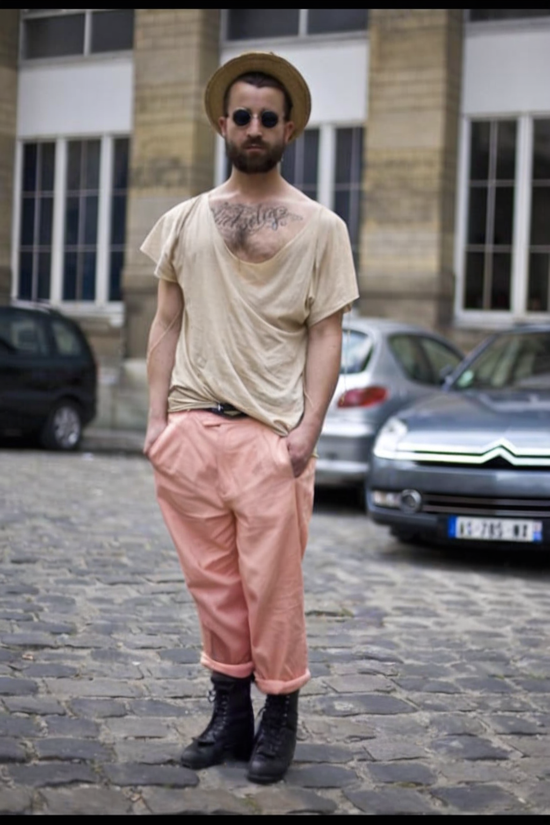

In [ ]:
for sample in dataset:
  if sample.id == '65d62bf37ba142b66e64bcbf':
    new_sample = transform_sample(sample, "boots", "A photorealistic photo of a woman wearing a red-colored nice looking boot all red  high resolution")
    dataset.add_sample(new_sample)
  #break